## Preparation 

### **Downloads**

In [1]:
!pip install nltk
import nltk
nltk.download('sentiwordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

### **Drive Data Loading**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_path = "/content/drive/MyDrive/IMDB Dataset.csv"

### **Imports**

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt; plt.rcdefaults()

In [5]:
# In order to clean and normaliaze the text
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import bigrams, WordNetLemmatizer
import re

In [6]:
# For the exploration phase
from collections import Counter

In [7]:
# For the unsupervised learning
from nltk.corpus import sentiwordnet as swn
from nltk.tag.perceptron import PerceptronTagger

In [8]:
# For the supervised learning 
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import Perceptron
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import KFold,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

## Question 1 - Text pre-processing and exploration

### **Pre Processing**

In [9]:
# load the imdb datset
df = pd.read_csv(data_path)

In [10]:
def remove_html_tags(review):
    regex = re.compile('<.*?>')
    review_wout_tags = re.sub(regex, '', review)
    return review_wout_tags

In [11]:
def lower_case(review):
    return review.lower()

In [12]:
def remove_special_char(review):
    review_wout_special = []

    for word in review.split():
        review_wout_special.append(re.sub(r"[^a-zA-Z0-9]+", ' ', word))
    
    joined_review_wout_special = ' '.join(review_wout_special)
    return joined_review_wout_special

In [13]:
def tokenization(review):
    return word_tokenize(review)

In [14]:
def remove_stopwords(review):
    stop_words = set(stopwords.words('english'))    
    filtered_sentence = [word for word in review if not word in stop_words]
    return filtered_sentence

In [15]:
def stemming(review):
    stem_review = []
    
    # stem each word
    for word in review:
        stem_review.append(ps.stem(word))
    
    return stem_review

In [16]:
def lemmatizing(review):
    lemmatized_review = []
    
    for word in review:
        lemmatized_review.append(wnl.lemmatize(word))
    
    return lemmatized_review

In [17]:
def label_encoding(sentiment):
    return 1 if sentiment == "positive" else 0

In [18]:
# Pre processing phase
def pre_processing(data):
    data['review']=data['review'].apply(remove_html_tags)
    data['review']=data['review'].apply(lower_case)
    data['review']=data['review'].apply(remove_special_char)
    data['review']=data['review'].apply(tokenization)
    data['review']=data['review'].apply(remove_stopwords)
    data['review']=data['review'].apply(stemming)
    # data['review']=data['review'].apply(lemmatizing)
    data['sentiment'] = data['sentiment'].apply(label_encoding)

In [19]:
df.drop_duplicates(inplace=True)
      
df_copy = df.copy()

ps = PorterStemmer()

#wnl = WordNetLemmatizer()

pre_processing(df_copy)

df_copy


,review,sentiment
0,"[one, review, mention, watch, 1, oz, episod, h...",1
1,"[wonder, littl, product, film, techniqu, unass...",1
2,"[thought, wonder, way, spend, time, hot, summe...",1
3,"[basic, famili, littl, boy, jake, think, zombi...",0
4,"[petter, mattei, love, time, money, visual, st...",1
...,...,...
49995,"[thought, movi, right, good, job, creativ, ori...",1
49996,"[bad, plot, bad, dialogu, bad, act, idiot, dir...",0
49997,"[cathol, taught, parochi, elementari, school, ...",0
49998,"[go, disagre, previou, comment, side, maltin, ...",0


### **Data Exploration** 

In [20]:
# calculates number of docs from each category
def number_of_docs():
    # number of docs from each category
    print(f"#of docs from each category \n{df['sentiment'].value_counts()}")

In [21]:
# calculate terms distribution
def term_dist():
    # terms distribution per category
    positive_terms = []
    negative_terms = []
    
    for index, row in df_copy.iterrows():
        if row['sentiment'] == 1:
            positive_terms.extend(row['review'])
        else:
            negative_terms.extend(row['review'])

    # distribution of unigram terms
    count_unigram(positive_terms, negative_terms)
    
    # create bigram terms
    positive_terms_bigram = bigrams(positive_terms)
    negative_terms_bigram = bigrams(negative_terms)
    # distribution of bigram terms
    count_bigram(positive_terms_bigram, negative_terms_bigram)
    
    # concatenate between unigram and bigram terms
    positive_terms_total = []
    positive_terms_total.extend(positive_terms)
    positive_terms_total.extend(positive_terms_bigram)

    negative_terms_total = []
    negative_terms_total.extend(negative_terms)
    negative_terms_total.extend(negative_terms_bigram)
    
    # Find the top 10 terms per category
    top10_terms(positive_terms_total, negative_terms_total)

In [22]:
# counts unigram per each category
def count_unigram(positive_terms, negative_terms):     
    count_positive = Counter()
    count_positive.update(positive_terms)
    discretization(count_positive, "Positive Unigrams")
    
    count_negative = Counter()
    count_negative.update(negative_terms)
    discretization(count_negative, "Negative Unigrams")

In [23]:
# counts bigram per each category
def count_bigram(positive_terms_bigram, negative_terms_bigram):
    count_positive_terms_bigram = Counter()
    count_positive_terms_bigram.update(positive_terms_bigram)
    discretization(count_positive_terms_bigram, "Positive Bigrams")
    
    count_negative_terms_bigram = Counter()
    count_negative_terms_bigram.update(negative_terms_bigram)
    discretization(count_negative_terms_bigram, "Negative Bigrams")

In [24]:
''' 
    discretize the counter values into bins according to equal width and equal freq - 
    divide the counter values into bins in order to create plots in which X-axis presents the bin and Y-axis presents
    the number of terms in that bin
'''
def discretization(counter, type):
    # convert counter to dataframe in order to use pandas functions for discretization
    data = pd.DataFrame.from_dict(counter, orient='index').reset_index().rename(columns={"index":"word", 0:"frequency"})
    
    # create subplots
    fig, axes = plt.subplots(nrows=1, ncols=2)
    plt.subplots_adjust(wspace=0.5,right=2) 
    
    discretization_equal_width(data, type, axes)
    discretization_equal_freq(data, type, axes)
    plt.show()
    plt.close()

# equal width discretization    
def discretization_equal_width(data, type, axes):
    
    data['bin_equal_width'] = pd.cut(data['frequency'],bins=20, precision=0) #split to 20 bins  
    df2 = data.groupby('bin_equal_width').bin_equal_width.count() # count number of terms in each bin
    
    # plot the data while y-axis is limited to the value of 400 because its value is too big and hence hides
    # the other data values
    df2.plot(ax=axes[0], kind='bar', xlabel='Equal width - Terms frequency bins', \
             ylabel='number of terms', title=f'{type} term distribution - Equal width',ylim=[0,1000])   

# equal freq discretization    
def discretization_equal_freq(data, type, axes):
    
    # tryting to split into 20 equal freq bins 
    data['bin_equal_freq'] = pd.qcut(data['frequency'],q=20, precision=0, duplicates='drop')   
    df3 = data.groupby('bin_equal_freq').bin_equal_freq.count() 
    df3.plot(ax=axes[1], kind='bar', xlabel='Equal frequency - Terms frequency bins', ylabel='number of terms', title=f'{type} term distribution - Equal frequency')   
    

In [25]:
# table of top 10 terms per category
def top10_terms(positive_terms_total, negative_terms_total):
    count_positive = Counter()
    count_positive.update(positive_terms_total)
    positive_data = [list(x) for x in count_positive.most_common(10)]
    print("Top 10 positive terms")
    draw_table(positive_data, 'Positive')
    
    count_negative = Counter()
    count_negative.update(negative_terms_total)
    negative_data = [list(x) for x in count_negative.most_common(10)]
    print("Top 10 negative terms")
    draw_table(negative_data, 'Negative')

def draw_table(data, type):
    fig = plt.figure(dpi=80)
    ax = fig.add_subplot(1,1,1)
    table = ax.table(cellText=data, loc='center',colLabels=[f'{type} term','Frequency'])
    table.set_fontsize(14)
    table.scale(1,2)
    ax.axis('off')
    plt.show()

**********Data Exploration:**********
#of docs from each category 
positive    24884
negative    24698
Name: sentiment, dtype: int64


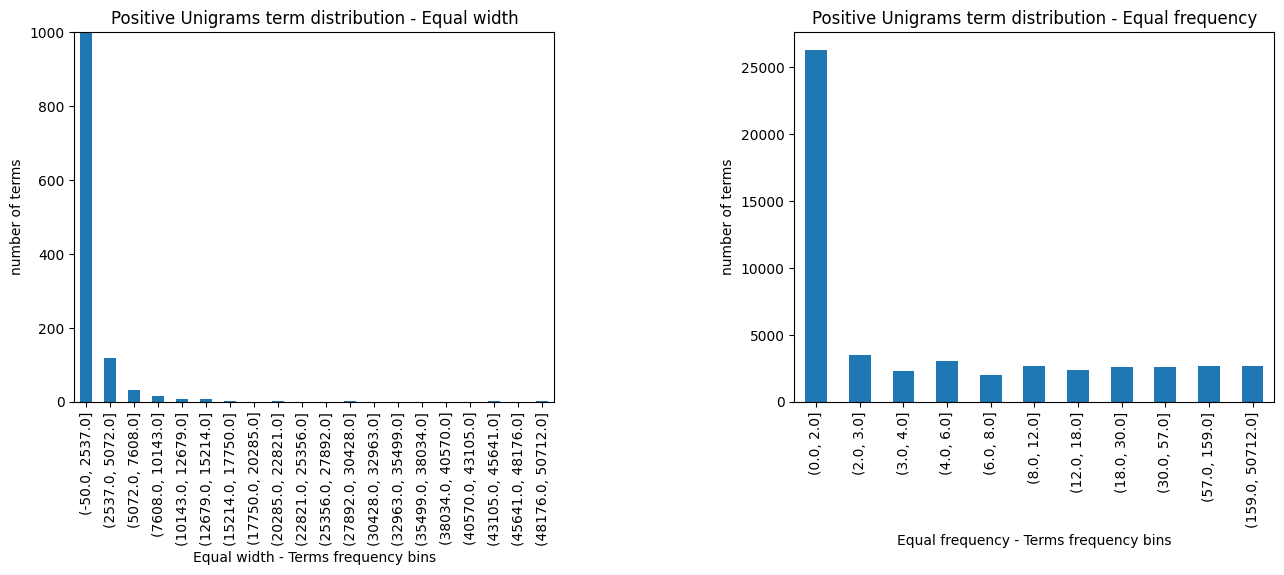

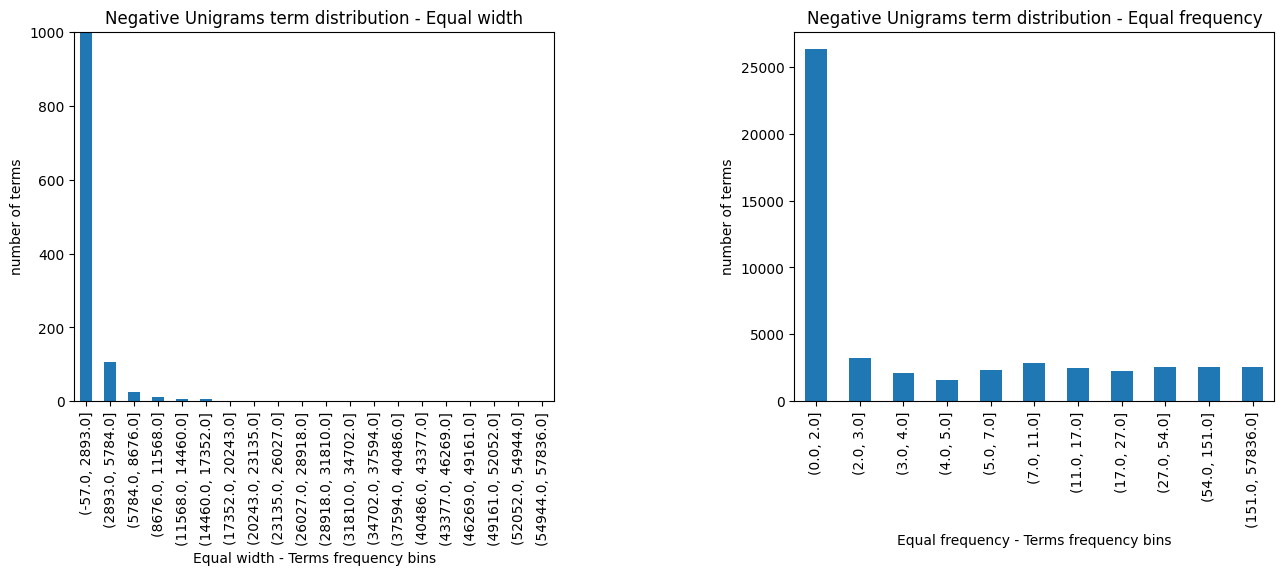

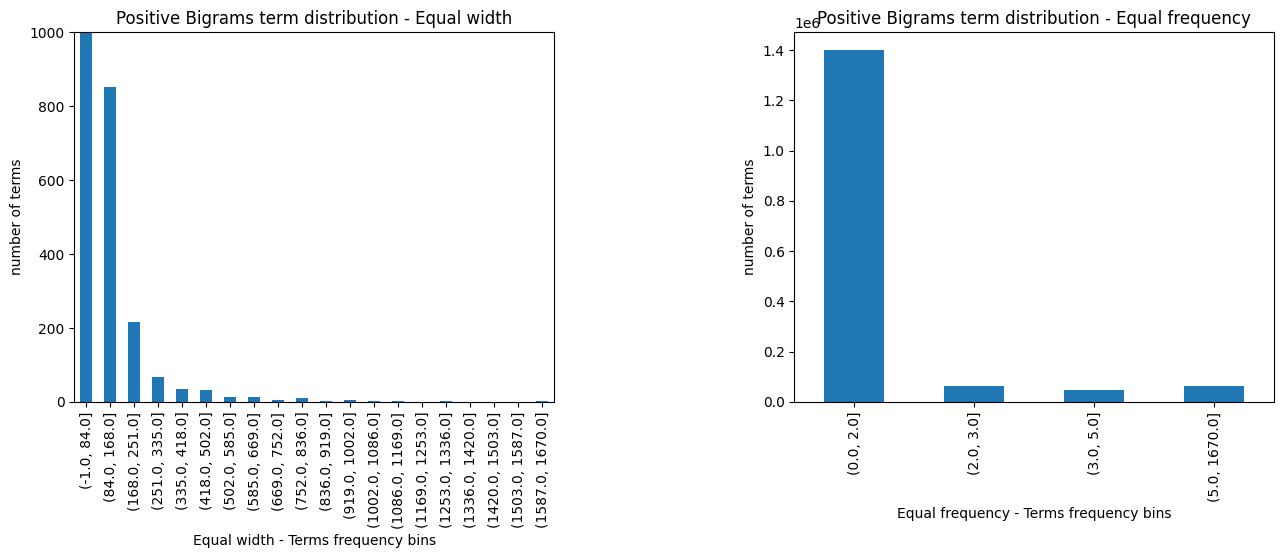

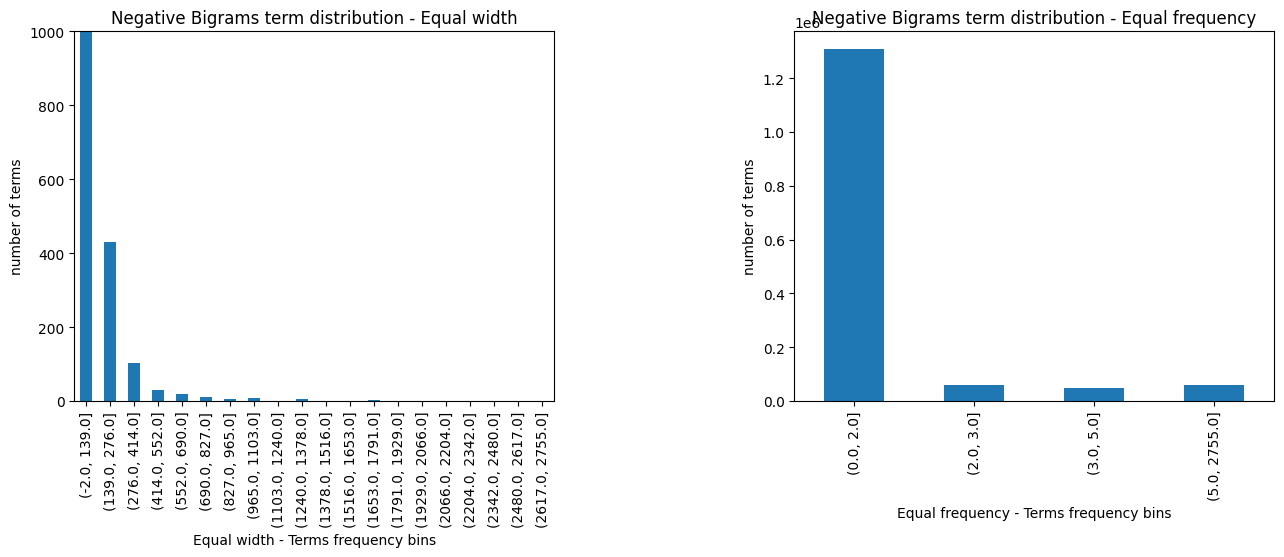

Top 10 positive terms


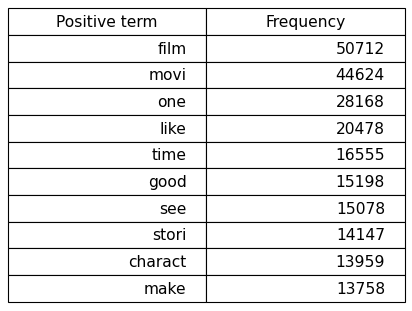

Top 10 negative terms


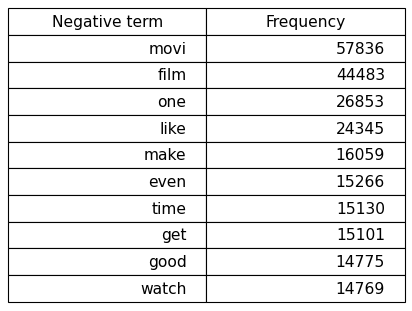

In [26]:
# Exploration of the dataset 
print('**********Data Exploration:**********')

number_of_docs()
term_dist()

### **Data Splitting - Train & Test sets**

In [27]:
# prepare data splitting
df_review = df_copy.copy()

# concatenate tokens into sentences in order to use feature extraction libraries
def join_sentences(review):
    return ' '.join(review)
    
df_review['review'] = df_review['review'].apply(join_sentences)

df_review

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_review['review'], 
                                                    df_review['sentiment'], 
                                                    train_size = 0.5, 
                                                    random_state=0)

### **Expected challenges:**
* Same words can have different sentiment meaning - negation problem.
* Which words we should use - whether we keep only adjectives that may express opinions or all words.
* How to interpret features - bag of words, tf-idf, etc.
* As we can see from the exploration phase, the most common unigram words are very similar, but the bigrams have different meaning. For example, the term good exists in both classes.
* Most of the words exist between 1-5 times on each class, so we got sparse vectors.

## Question 2  - Document classification – un-supervised learning

### **Pos Tagging**

In [28]:
#Create POS tagging for each token
def tag_tokens(row):
    return tagger.tag(row)

# split sentences to tokens in order to tag each word
def split_tokens(row):
    return row.split()

tagger = PerceptronTagger() 
X_test_tagged = X_test.apply(split_tokens).apply(tag_tokens)
X_test_tagged

166      [(origin, NN), (tenaci, NN), (fan, NN), (first...
28039    [(first, RB), (rate, NN), (western, JJ), (tale...
35960    [(one, CD), (time, NN), (great, JJ), (scienc, ...
1872     [(mickey, NN), (rourk, NN), (famou, NN), (movi...
12728    [(worst, JJS), (movi, NN), (ive, JJ), (ever, R...
                               ...                        
13614    [(sweden, NN), (seen, VBN), (movi, JJ), (thing...
15086    [(second, JJ), (animatrix, NN), (short, JJ), (...
1172     [(like, IN), (movi, NN), (lot, NN), (realli, V...
33423    [(charm, NN), (awesom, NN), (get, VBP), (pheob...
22754    [(dream, NN), (julia, NN), (titl, NN), (origin...
Name: review, Length: 24791, dtype: object

### **Sentiment Analysis**

In [29]:
sentiment_list = []

def sentiment_analysis(review):
    review_scores = []
    for idx,t in enumerate(review):  #t[0] word, t[1] pos tag
        newtag=''
        if t[1].startswith('NN'):
            newtag='n'
        elif t[1].startswith('JJ'):
            newtag='a'
        elif t[1].startswith('V'):
            newtag='v'
        elif t[1].startswith('R'):
            newtag='r'
        else:
            newtag=''       
        if(newtag!=''):    
            synsets = list(swn.senti_synsets(t[0], newtag))
            #synsets contains for each token the probability for negative, positive and objective
            #Getting average of all possible sentiments       
            score=0
            if(len(synsets)>0):
                for syn in synsets:
                    score+=syn.pos_score()-syn.neg_score()
                review_scores.append(score/len(synsets))
    
    review_sentiment = 1 if sum(review_scores) / len(review_scores) >= 0  else 0
    sentiment_list.append(review_sentiment)
        
X_test_tagged.apply(sentiment_analysis)

166      None
28039    None
35960    None
1872     None
12728    None
         ... 
13614    None
15086    None
1172     None
33423    None
22754    None
Name: review, Length: 24791, dtype: object

### **Calculate Accuracy**

In [30]:
def calculate_accuracy():
    report = classification_report(y_test, sentiment_list)
    print(report)
    print(f"The model accuracy is: {roc_auc_score(y_test, sentiment_list)*100}%")  

print("The Unsupervised Learning Model Accuracy:")
calculate_accuracy() 

The Unsupervised Learning Model Accuracy:
              precision    recall  f1-score   support

           0       0.71      0.46      0.56     12284
           1       0.61      0.82      0.70     12507

    accuracy                           0.64     24791
   macro avg       0.66      0.64      0.63     24791
weighted avg       0.66      0.64      0.63     24791

The model accuracy is: 63.75057938899056%


## Question 3 - Document classification – supervised learning

### **Feature Extraction Methods**

In [31]:
feature_extraction_methods = [(CountVectorizer(),'bag_of_words'), (TfidfVectorizer(), 'TF-IDF')]

### **Machine Learning Methods**

In [32]:
models = [(LinearSVC(),'SVM'),(MultinomialNB(), "MultinomialNB"), (Perceptron(), 'Perceptron')]

### **Models Tuning + Comparison between the different models**

In [33]:
# Grid search of combinations of feature extraction methods and machine learning methods with different parameters 
# in order to find the best combination 
def tune_model(model, model_name, feature_method, feature_method_name, parameters, k_fold):
    print("=" * 80)
    print(f"Model: {model_name}")
    print(f"Featrue extraction method: {feature_method_name}")
    print("_" * 80)
    nb_clf = Pipeline([('vect', feature_method),('clf', model)])
    gs_clf = GridSearchCV(nb_clf, parameters, n_jobs=-1, cv=k_fold)
    gs_clf = gs_clf.fit(X_train,y_train)
    print('Best score: ', gs_clf.best_score_)
    print('Best params: ', gs_clf.best_params_)

In [34]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

# Testing the impact of changing at least one parameter per feature extraction and machine learning model on classification result
# feature extraction parameter - ngram_range
# machine learning method parameter - max_iter/ alpha
parameters = [{'vect__ngram_range': [(1,2),(1,1)], 'clf__max_iter': [1000,2000]},
            {'vect__ngram_range': [(1,2),(1,1)], 'clf__alpha': [0.5,1.0]},
            {'vect__ngram_range': [(1,2),(1,1)], 'clf__alpha': [0.01,0.0001]}]

for model_index, (model, model_name) in enumerate(models):
    for method, method_name in feature_extraction_methods:
        tune_model(model, model_name, method, method_name,parameters[model_index], k_fold)

Model: SVM
Featrue extraction method: bag_of_words
________________________________________________________________________________
Best score:  0.8887902575179897
Best params:  {'clf__max_iter': 1000, 'vect__ngram_range': (1, 2)}
Model: SVM
Featrue extraction method: TF-IDF
________________________________________________________________________________
Best score:  0.9000038061653373
Best params:  {'clf__max_iter': 1000, 'vect__ngram_range': (1, 2)}
Model: MultinomialNB
Featrue extraction method: bag_of_words
________________________________________________________________________________
Best score:  0.8734213359965647
Best params:  {'clf__alpha': 1.0, 'vect__ngram_range': (1, 2)}
Model: MultinomialNB
Featrue extraction method: TF-IDF
________________________________________________________________________________
Best score:  0.8803190835274369
Best params:  {'clf__alpha': 0.5, 'vect__ngram_range': (1, 2)}
Model: Perceptron
Featrue extraction method: bag_of_words
__________________

### **Using Best Model on Test Set**

In [35]:
# Using the best model selected in the previous steps for prediction on the test set. The best model - SVM + TF-IDF

tf =    TfidfVectorizer(ngram_range = (1,2))
                                
svm = LinearSVC()

svm.fit(tf.fit_transform(X_train), y_train)
prediction = svm.predict(tf.transform(X_test))

report = classification_report(y_test, prediction)
print(report)
print(f"The model accuracy is: {roc_auc_score(y_test, prediction)*100}%")

              precision    recall  f1-score   support

           0       0.91      0.88      0.89     12284
           1       0.88      0.91      0.90     12507

    accuracy                           0.90     24791
   macro avg       0.90      0.90      0.90     24791
weighted avg       0.90      0.90      0.90     24791

The model accuracy is: 89.51353116562768%


### **Task challenges and effective solutions**
* All the challenges from the first question.
* Which machine learning model to use?
* Which feature extraction method to use?
* Which parameters to use? (calssification model and feature extraction method)
* Solutions - 
* use grid search in order to find the best combination.
* In order to deal with sparsity - use sparse matrix.
* use bigrams in order to solve ambiguity.



## Question 4 - Supervised vs. Unsupervised learning approach

### **Advantages & Disadvantages**

The supervised learning model accuracy is 89.51% and the un-supervised learning model accuracy is 63.75%.
The advantages of each approach:
- Supervised - 
 * Much more accurate than unsupervised classification.
 * No need to set Part of speech for each word.
 
- Unsupervised - 
 * No prior knowledge is required, therefore the data is more objective.
 * Can use words that does not exist in the train set.

### **Combined Approach Suggestion**

Suggestion of an approach that combines both models:
1. Train the model with supervised learning approach.
2. predict the test set with the help of the train set 
3. use the decision_function in order to see the confidence of each decision
4. choose the decisions with low confidence
5. use the unsupervised learning approach to find out if according to this approach the decision is different
6. if the decision is different change the decision

Explanation:
* Because the samples which their confidence is very low, we can guess that these samples contain neural words, or ambiguity words. So, if we use a pre-defined dictionary that may tag each word with its sentiment it maybe would change the decision of these samples.

### **Implementation**

In [36]:
reviwes_scores_v2 = [] 

# calculate scores for each raview
def sentiment_analysis(review):
    review_scores = []
    for idx,t in enumerate(review):  #t[0] word, t[1] pos tag
        newtag=''
        if t[1].startswith('NN'):
            newtag='n'
        elif t[1].startswith('JJ'):
            newtag='a'
        elif t[1].startswith('V'):
            newtag='v'
        elif t[1].startswith('R'):
            newtag='r'
        else:
            newtag=''       
        if(newtag!=''):    
            synsets = list(swn.senti_synsets(t[0], newtag))
            #synsets contains for each token the probability for negative, positive and objective
            #Getting average of all possible sentiments       
            score=0
            if(len(synsets)>0):
                for syn in synsets:
                    score+=syn.pos_score()-syn.neg_score()
                review_scores.append(score/len(synsets))
    
    review_sentiment = sum(review_scores) / len(review_scores)
    reviwes_scores_v2.append(review_sentiment)
    
X_test_tagged.apply(sentiment_analysis)

166      None
28039    None
35960    None
1872     None
12728    None
         ... 
13614    None
15086    None
1172     None
33423    None
22754    None
Name: review, Length: 24791, dtype: object

In [37]:
# use supervised learning to train the model and predict the test set.
tf =    TfidfVectorizer(ngram_range = (1,2))
                                
svm = LinearSVC()

svm.fit(tf.fit_transform(X_train), y_train)
prediction = svm.predict(tf.transform(X_test))

In [38]:
# calculate decision function
decision = svm.decision_function(tf.transform(X_test))

In [39]:
# prepare data 
decision_list = list(decision)
prediction_v2 = prediction.copy()

# accuracy before the new approach
print(f"The model accuracy is: {roc_auc_score(y_test, prediction_v2)*100}%")
counter = 0

# test each decision if it is confident or not. if the decision confidence is between -0.0015<x<0.0015 use
# usupervised learning approach and change the decision according to the given score. 
for i,x in enumerate(decision_list):
    if x<=0.0015 and x>=-0.0015:
        if reviwes_scores_v2[i] >= 0 and prediction[i] == 0:
            prediction_v2[i] = 1
            counter +=1

        elif reviwes_scores_v2[i] < 0 and prediction[i] == 1:
            prediction_v2[i] = 0
            counter +=1
            
print(f"Number of decisions that were changed: {counter}")
print(f"The new model accuracy is: {roc_auc_score(y_test, prediction_v2)*100}%")

The model accuracy is: 89.51353116562768%
Number of decisions that were changed: 7
The new model accuracy is: 89.52566959767265%


### **Discussion**
* with this approach and with threshold of 0.0015, the decision of 7 samples was changed, and the accuracy increased a little by 0.012%.